In [1]:
import os
import sys
import cv2
import numpy as np
from dataclasses import dataclass

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)

from utils.config import Config

camera_matrix = Config.INTRINSICS_STEREO

@dataclass
class TrackedFeature:
    unique_id: str
    first_seen_frame_idx: int
    
    def __post_init__(self):
        self.age = 0
        self.match_list = []

    def add_feature(self, frame_idx, keypoint, descriptor, xyz):
        self.match_list.append((frame_idx, keypoint, descriptor, xyz))


class Registry:
    def __init__(self):
        self.active_features = []
        self.discarded_features = []
        self.poses = []

    def register_frame(self, i, color, depth, corrected_depth):
        frame_idx = i
        active_features = self.active_features.copy()
        extracted_features = self.detect_ORBs(depth, cv2.cvtColor(color, cv2.COLOR_BGR2GRAY))
        matched_features = []
        for keypoint, descriptor, xyz in extracted_features:
            matched = False
            for tracked_feature in active_features:
                last_match_i, last_match_kp, last_match_desc, last_match_xyz = tracked_feature.match_list[-1]

                if self.compare_descriptors(last_match_desc, descriptor):
                    dx = last_match_kp.pt[0] - keypoint.pt[0]
                    dy = last_match_kp.pt[1] - keypoint.pt[1]
                    if dx * dx + dy * dy < 100:
                        tracked_feature.add_feature(frame_idx, keypoint, descriptor, xyz)
                        matched = True
                        matched_features.append(tracked_feature)
                        tracked_feature.age = 0
                        break

            if not matched:
                unique_id = f"{frame_idx}_{hash(descriptor.tobytes())}_{keypoint.pt[0]:.1f}_{keypoint.pt[1]:.1f}"
                new_feature = TrackedFeature(unique_id, frame_idx)
                new_feature.add_feature(frame_idx, keypoint, descriptor, xyz)
                self.active_features.append(new_feature)

        self.age_features()

        if frame_idx == 0:
            init_pose = np.eye(4, dtype=np.float32)
            self.poses.append(init_pose)
        else:
            prev_pose = self.poses[-1]
            T = self.estimate_pose_change(matched_features)
            if T is not None:
                new_pose = prev_pose @ np.linalg.inv(T)
                self.poses.append(new_pose)

            else:
                return

    def detect_ORBs(self, depth, gray) -> list:
        orb = cv2.ORB.create()
        mask = (depth > 0).astype(np.uint8) * 255
        keypoints, descriptors = orb.detectAndCompute(gray, mask)
        points3d = cv2.rgbd.depthTo3d(depth, camera_matrix)

        xyz_list = []
        for kp in keypoints:
            x, y = int(kp.pt[0]), int(kp.pt[1])
            xyz = points3d[int(y), int(x)]
            xyz_list.append(xyz)

        extracted_features = list(zip(keypoints, descriptors, xyz_list))

        return extracted_features

    def compare_descriptors(self, desc1, desc2) -> bool:
        return cv2.norm(desc1, desc2, cv2.NORM_HAMMING) < 30

    def age_features(self):
        for feature in self.active_features:
            feature.age += 1
            if feature.age > 10:
                self.discarded_features.append(feature)
                self.active_features.remove(feature)

    def estimate_pose_change(self, matched_features):
        object_points = []
        image_points = []

        for feature in matched_features:
            frame_idx_prev, _, _, xyz_prev = feature.match_list[-2]
            frame_idx_curr, curr_kp, _, _ = feature.match_list[-1]
            if frame_idx_prev != frame_idx_curr:
                if not np.any(np.isnan(xyz_prev)) and not np.allclose(xyz_prev, [0,0,0]):
                    object_points.append(xyz_prev)
                    image_points.append((curr_kp.pt[0], curr_kp.pt[1]))
    
        object_points = np.array(object_points, dtype=np.float32)
        image_points = np.array(image_points, dtype=np.float32)
        
        object_points = np.array(object_points, dtype=np.float32)
        image_points = np.array(image_points, dtype=np.float32)
        
        if len(object_points) < 6 or len(image_points) < 6:
            return None
        
        success, rvec, tvec = cv2.solvePnP(
            object_points,
            image_points,
            camera_matrix,
            np.zeros((4, 1), dtype=np.float32),
            flags=cv2.SOLVEPNP_ITERATIVE
        )

        if not success:
            return None

        if success:
            R, _ = cv2.Rodrigues(rvec)
            t = tvec.reshape(3)
            T = np.eye(4)
            #T[:3, :3] = R
            T[:3, 3] = t
        return T

In [2]:
import open3d as o3d
import csv

from utils.config import Config
from utils.data import RGBDDataset, FrameData
from utils.vis import Visualizer
from utils.depth import correct_depth, clip_depth
from utils.pcd import create_pcd_from_rgbd, clip_radially

data_path = os.path.join(current_dir, Config.DATA_PATH)
dataset = RGBDDataset(data_path)
vis = Visualizer()

# run_03_syn (773 frames) processing notes:
# The first usable frame is 146 due to insufficient features in the first rolled section.
# Weld section entrance occurs at frame 195 (+15).
# Weld section itself starts at frame 285 (+30).
# Exit from the weld section begins at frame 345 (+15).

start_frame = 146
frame_count = 1

def dump_pcd_to_csv(frame_idx: int, pcd: o3d.geometry.PointCloud, csv_path: str):
    points = np.asarray(pcd.points)
    colors = np.asarray(pcd.colors)

    valid = points[:, 2] > 0
    points = points[valid]
    colors = colors[valid]

    with open(csv_path, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "frame_idx", "u", "v", "x", "y", "z", "r", "g", "b"
        ])
        for p, c in zip(points, colors):
            x, y, z = p
            if z <= 0:
                continue
            u = (x * Config.FX_STEREO / z) + Config.CX
            v = (y * Config.FY_STEREO / z) + Config.CY
            
            writer.writerow([
                frame_idx,
                float(u), float(v),
                float(x), float(y), float(z),
                float(c[0]), float(c[1]), float(c[2]),
            ])

data_path = Config.DATA_PATH
output_dir = os.path.join(data_path, "output_csv")
os.makedirs(output_dir, exist_ok=True)

regis = Registry()
global_pcd = o3d.geometry.PointCloud()
for i in range(frame_count):
    frame_idx = start_frame + i
    frame: FrameData = dataset[frame_idx] # type: ignore
    color = frame['color']
    depth = frame['depth_raw']
    corrected_depth, _ = correct_depth(depth)
    clipped_depth = clip_depth(corrected_depth, 225.0, 325.0)
    pcd = create_pcd_from_rgbd(clipped_depth, color)
    radially_clipped_pcd = clip_radially(pcd)
    prev_pose_count = len(regis.poses)
    regis.register_frame(i, color, depth, corrected_depth)
    if len(regis.poses) == prev_pose_count:
        print(f"Skipping frame {frame_idx} due to pose estimation failure.")
        continue
    pose = regis.poses[-1]

    radially_clipped_pcd.transform(pose)

    csv_path = os.path.join(output_dir, f"frame_{frame_idx}.csv")
    dump_pcd_to_csv(frame_idx, radially_clipped_pcd, csv_path)

    #global_pcd += radially_clipped_pcd

#vis.pointcloud(global_pcd)



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


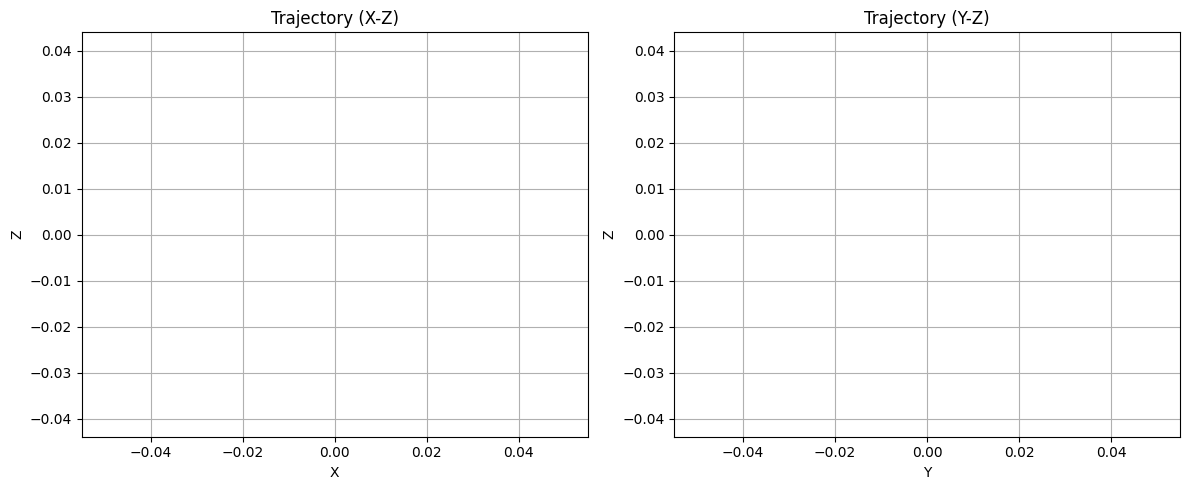

In [3]:
import matplotlib.pyplot as plt
import numpy as np

poses = np.stack(regis.poses, axis=0)  # Shape: (N, 4, 4)

xs = poses[:, 0, 3]
ys = poses[:, 1, 3]
zs = poses[:, 2, 3]

N = len(xs)
colors = plt.get_cmap('viridis')(np.linspace(0, 1, N))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for i in range(N - 1):
    plt.plot(xs[i:i+2], zs[i:i+2], color=colors[i], marker='o')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Trajectory (X-Z)')
plt.grid(True)
plt.axis('equal')

plt.subplot(1, 2, 2)
for i in range(N - 1):
    plt.plot(ys[i:i+2], zs[i:i+2], color=colors[i], marker='o')
plt.xlabel('Y')
plt.ylabel('Z')
plt.title('Trajectory (Y-Z)')
plt.grid(True)
plt.axis('equal')

plt.tight_layout()
plt.show()

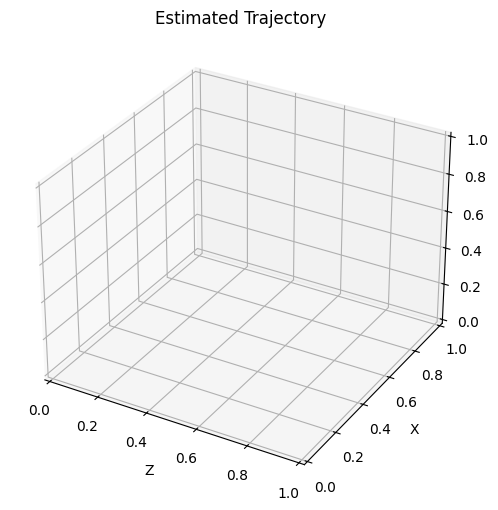

In [4]:
import numpy as np
import matplotlib.pyplot as plt

poses = np.stack(regis.poses, axis=0)

xs = poses[:, 2, 3]
ys = poses[:, 0, 3]
zs = poses[:, 1, 3]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

N = len(xs)
colors = plt.get_cmap('viridis')(np.linspace(0, 1, N))

for i in range(N - 1):
    ax.plot(xs[i:i+2], ys[i:i+2], zs[i:i+2], color=colors[i], marker='o')

ax.set(xlabel='Z', ylabel='X', zlabel='Y')
ax.set_title('Estimated Trajectory')
plt.show()